<a href="https://colab.research.google.com/github/mailbox-lab/Developing_Data_Products/blob/master/Rice_disease_classifier_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install kaggle

In [ ]:
import subprocess

# Command to download the dataset
command = "kaggle datasets download -d vbookshelf/rice-leaf-diseases"

# Execute the command
subprocess.run(command, shell=True)

CompletedProcess(args='kaggle datasets download -d vbookshelf/rice-leaf-diseases', returncode=0)

In [ ]:
# unzipping the data
!unzip /content/rice-leaf-diseases.zip -d /content/rice-leaf-diseases

Archive:  /content/rice-leaf-diseases.zip
  inflating: /content/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight/DSC_0365.JPG  
  inflating: /content/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight/DSC_0366.jpg  
  inflating: /content/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight/DSC_0367.JPG  
  inflating: /content/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight/DSC_0370.jpg  
  inflating: /content/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight/DSC_0372.JPG  
  inflating: /content/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight/DSC_0373.JPG  
  inflating: /content/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight/DSC_0374.JPG  
  inflating: /content/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight/DSC_0375.JPG  
  inflating: /content/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight/DSC_0376.JPG  
  inflating: /content/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight/DSC

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib
# Path to the dataset in your Google Drive
data_dir = 'rice-leaf-diseases/rice_leaf_diseases'

In [ ]:
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

53


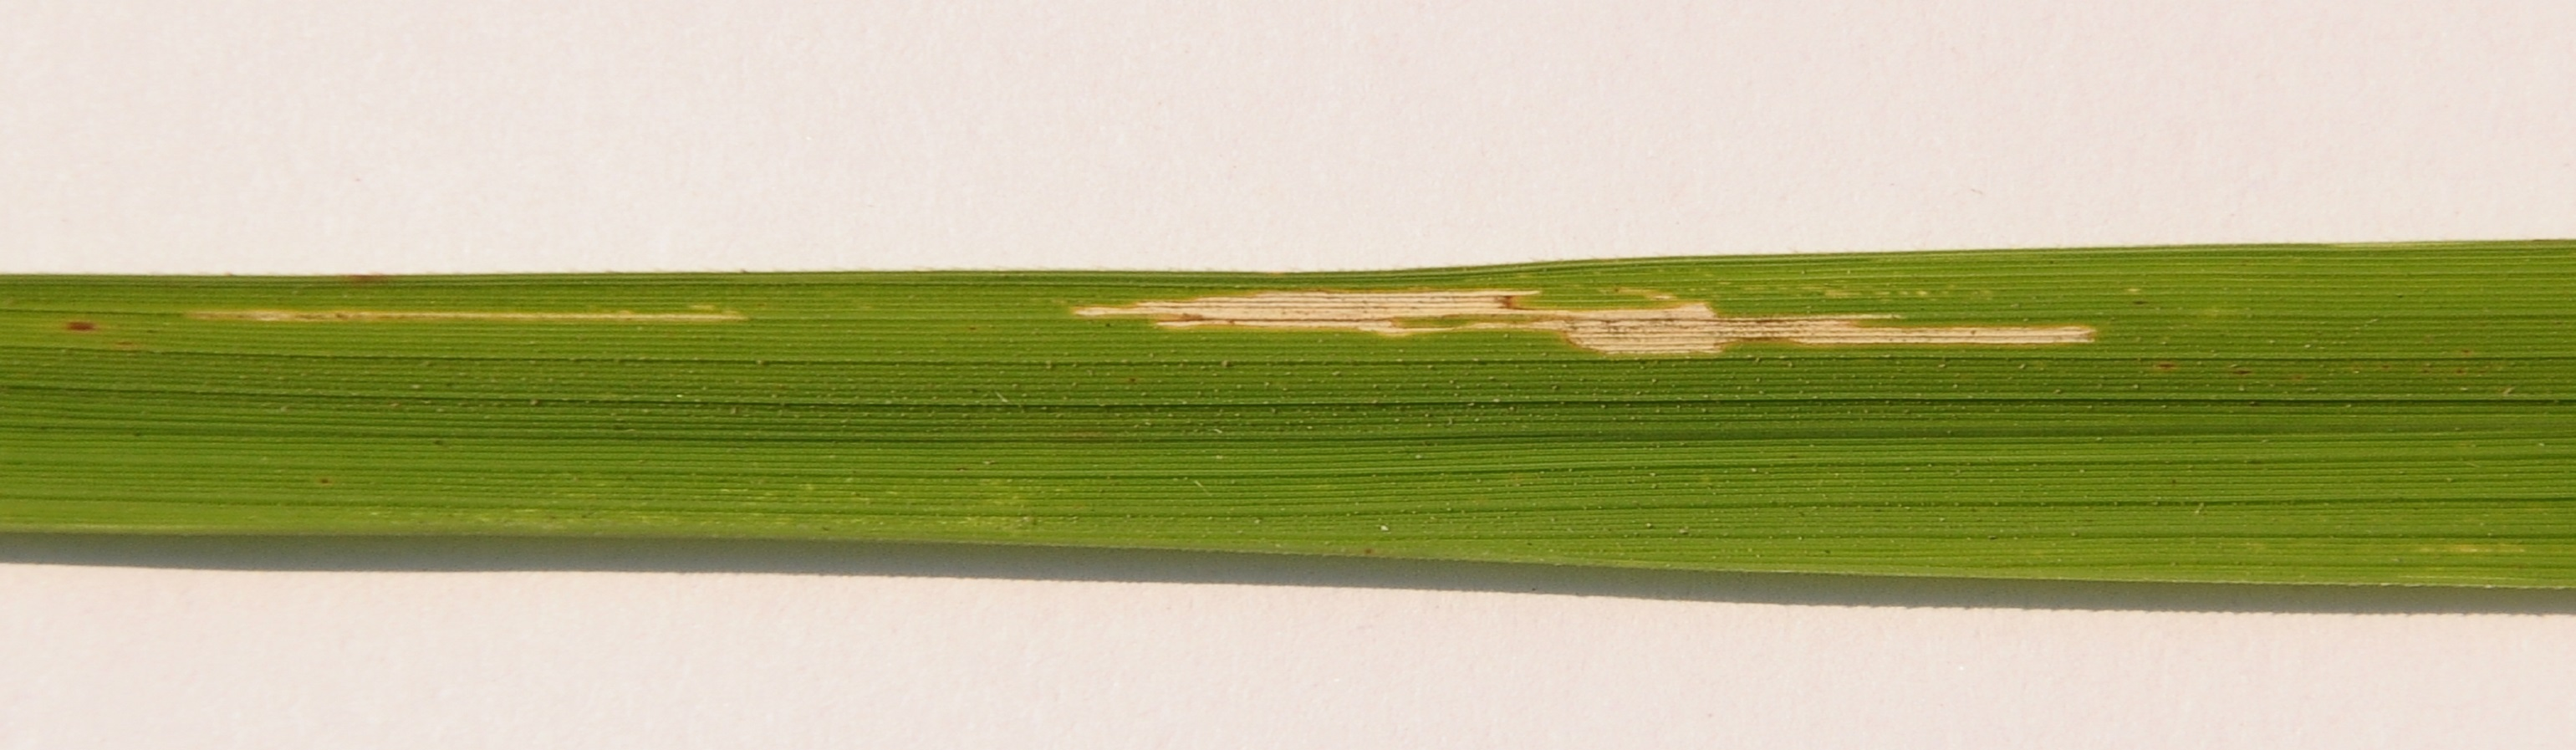

In [ ]:
Bacterial_leaf_blight= list(data_dir.glob('Bacterial leaf blight/*'))
PIL.Image.open(str(Bacterial_leaf_blight[0]))

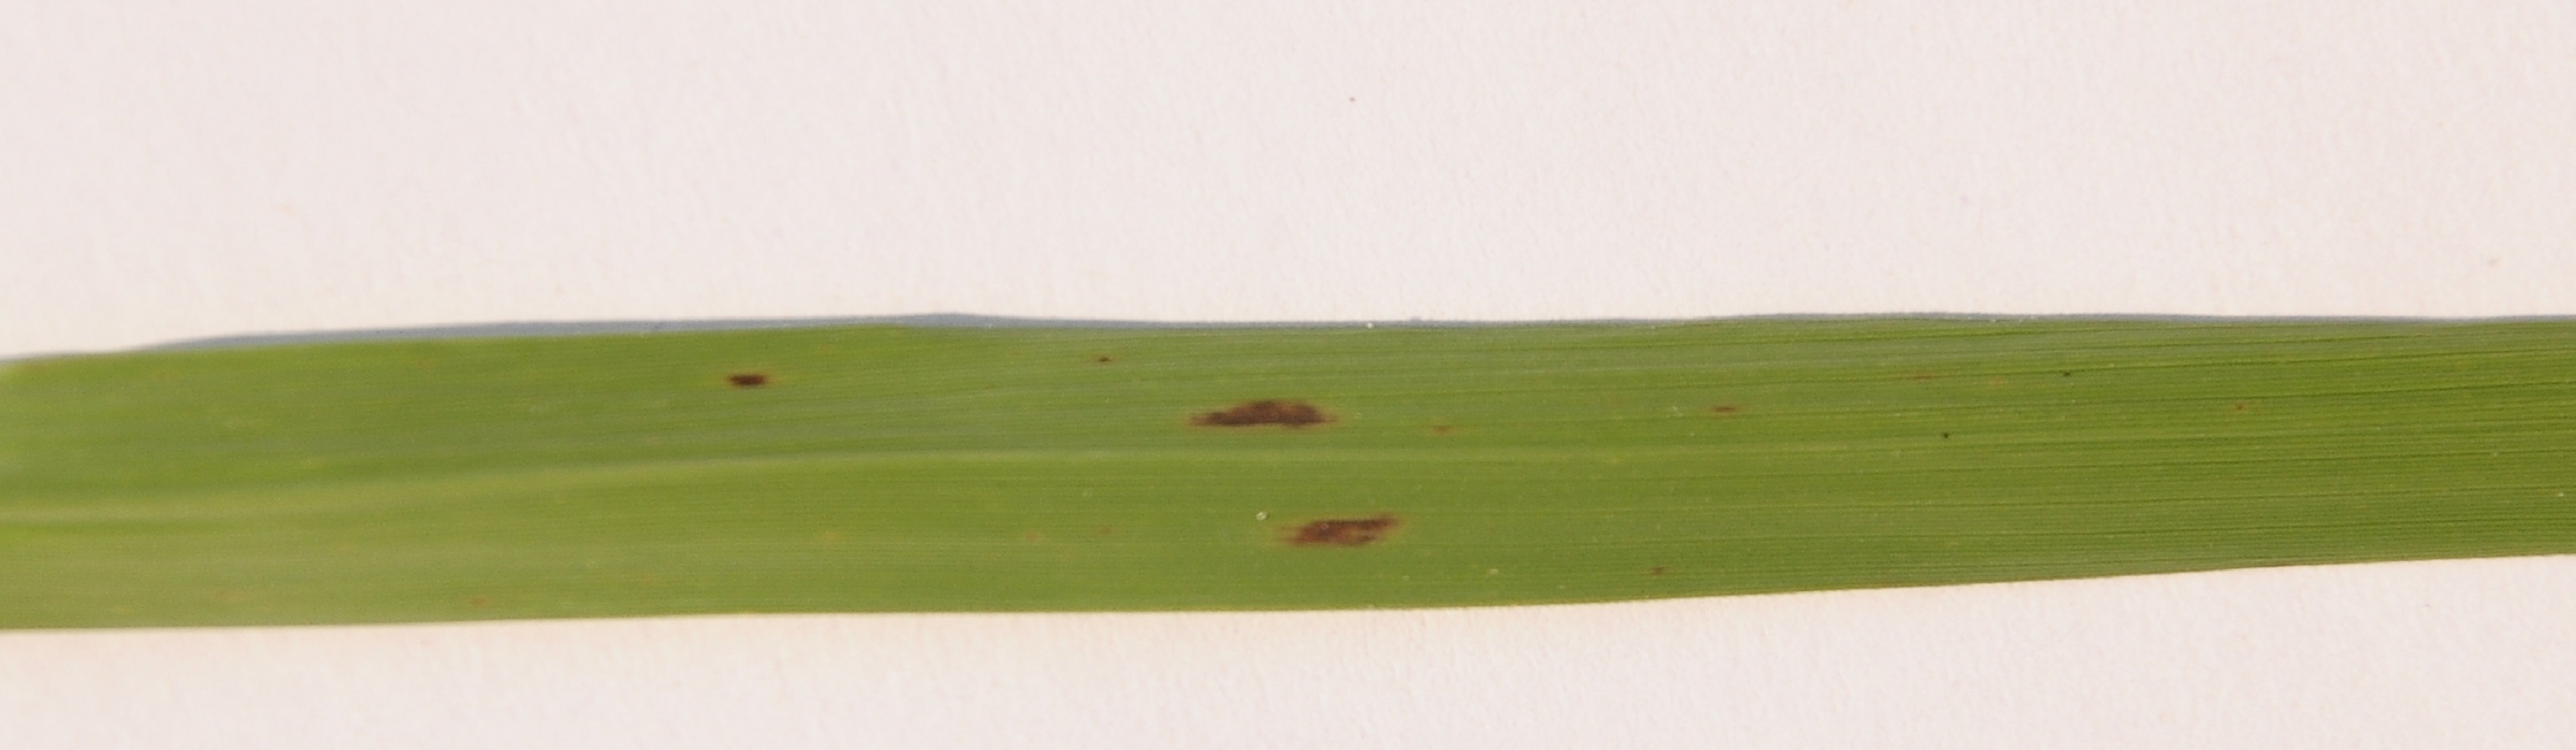

In [ ]:
Brown_spot = list(data_dir.glob('Brown spot/*'))
PIL.Image.open(str(Brown_spot[1]))

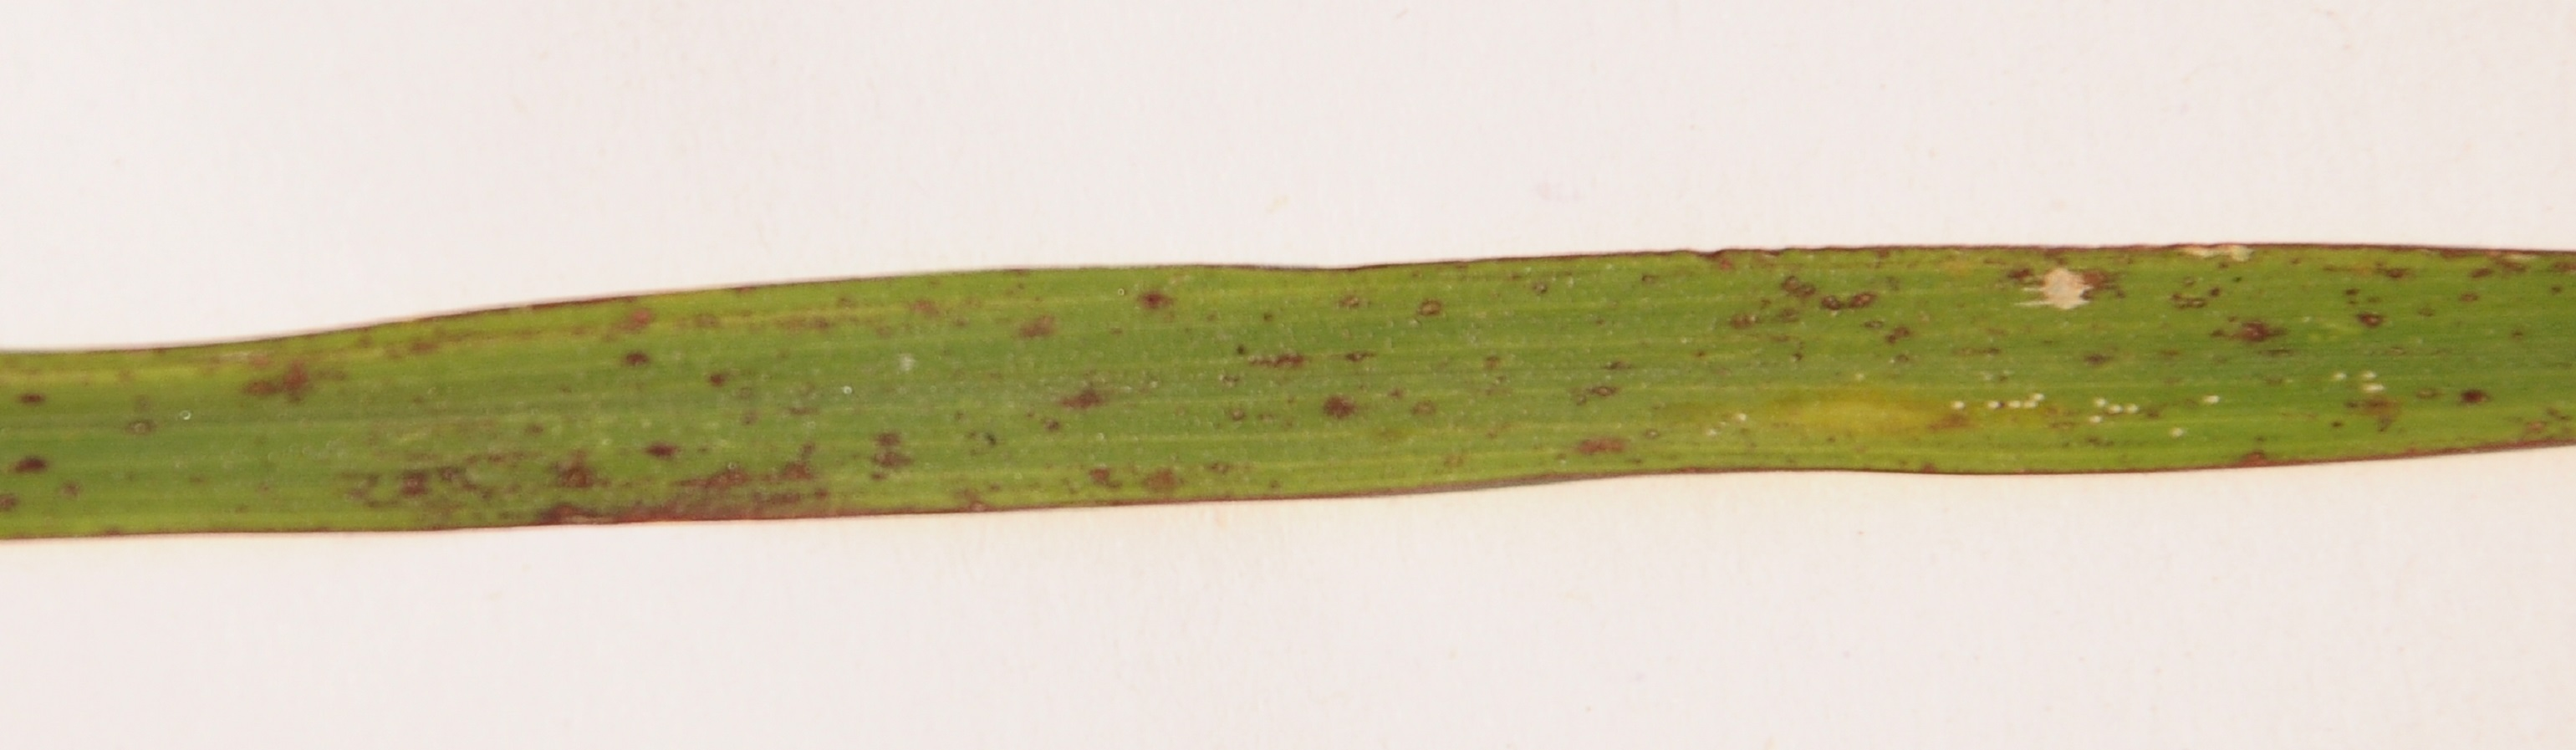

In [ ]:
Leaf_smut = list(data_dir.glob('Leaf smut/*'))
PIL.Image.open(str(Leaf_smut[2]))

In [ ]:
batch_size = 16
img_height = 224
img_width = 224

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=2,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 120 files belonging to 3 classes.
Using 96 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=2,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 120 files belonging to 3 classes.
Using 24 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


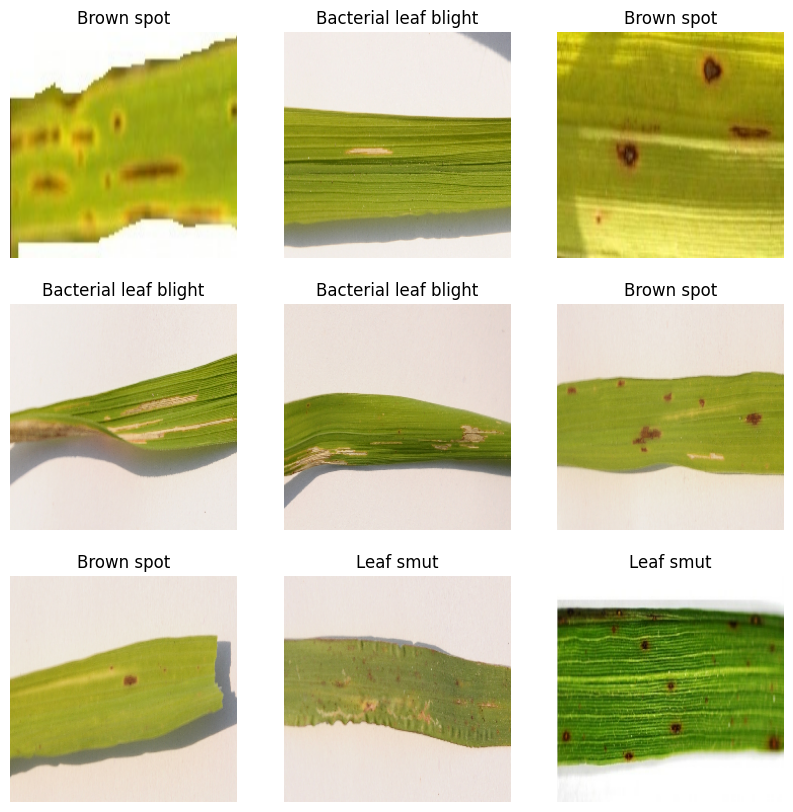

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",
                       input_shape=(img_height,
                                    img_width,
                                    3)),
    layers.RandomRotation(0.1, seed=2),
    layers.RandomZoom(0.1, seed=2),
    layers.RandomFlip(seed=2),
    layers.RandomBrightness(0.2, seed=2),
    layers.RandomContrast(0.3, seed=2),
])

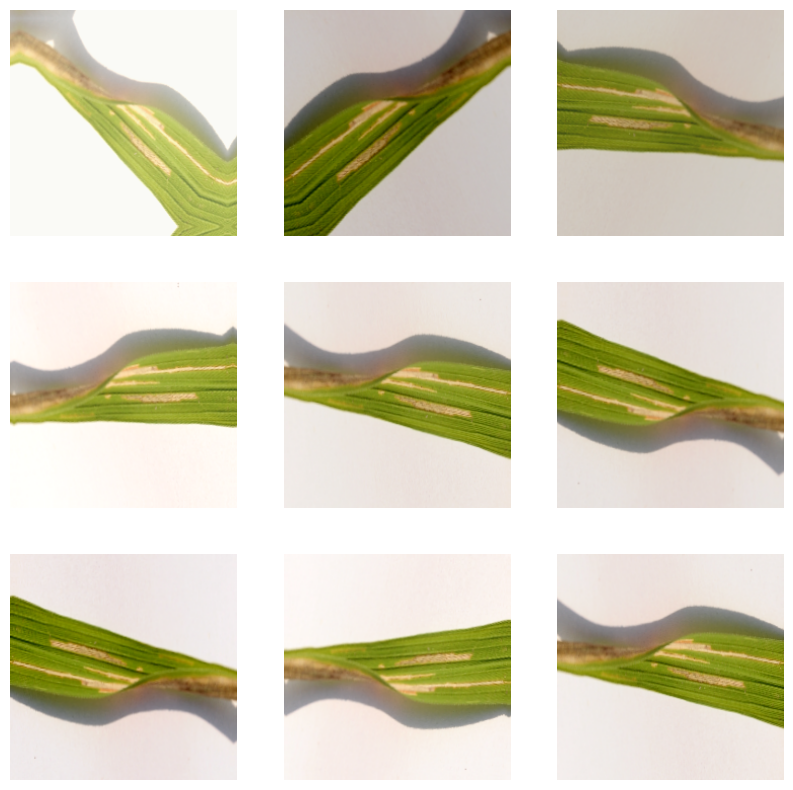

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
from tensorflow.keras import layers, models

In [ ]:
from tensorflow.keras.applications import MobileNetV3Large
num_classes = len(class_names)
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

12683000/12683000 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 128)               123008    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                       

In [ ]:
epochs=21
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/21
6/6 [==============================] - 10s 459ms/step - loss: 1.3504 - accuracy: 0.3854 - val_loss: 0.5529 - val_accuracy: 0.7917
Epoch 2/21
6/6 [==============================] - 0s 34ms/step - loss: 0.8161 - accuracy: 0.5938 - val_loss: 0.3634 - val_accuracy: 0.8333
Epoch 3/21
6/6 [==============================] - 0s 34ms/step - loss: 0.5033 - accuracy: 0.7812 - val_loss: 0.1778 - val_accuracy: 0.9583
Epoch 4/21
6/6 [==============================] - 0s 28ms/step - loss: 0.4010 - accuracy: 0.8646 - val_loss: 0.1365 - val_accuracy: 0.9583
Epoch 5/21
6/6 [==============================] - 0s 28ms/step - loss: 0.2548 - accuracy: 0.9062 - val_loss: 0.1044 - val_accuracy: 1.0000
Epoch 6/21
6/6 [==============================] - 0s 29ms/step - loss: 0.2750 - accuracy: 0.8646 - val_loss: 0.0836 - val_accuracy: 1.0000
Epoch 7/21
6/6 [==============================] - 0s 30ms/step - loss: 0.1756 - accuracy: 0.9375 - val_loss: 0.0576 - val_accuracy: 1.0000
Epoch 8/21
6/6 [=========

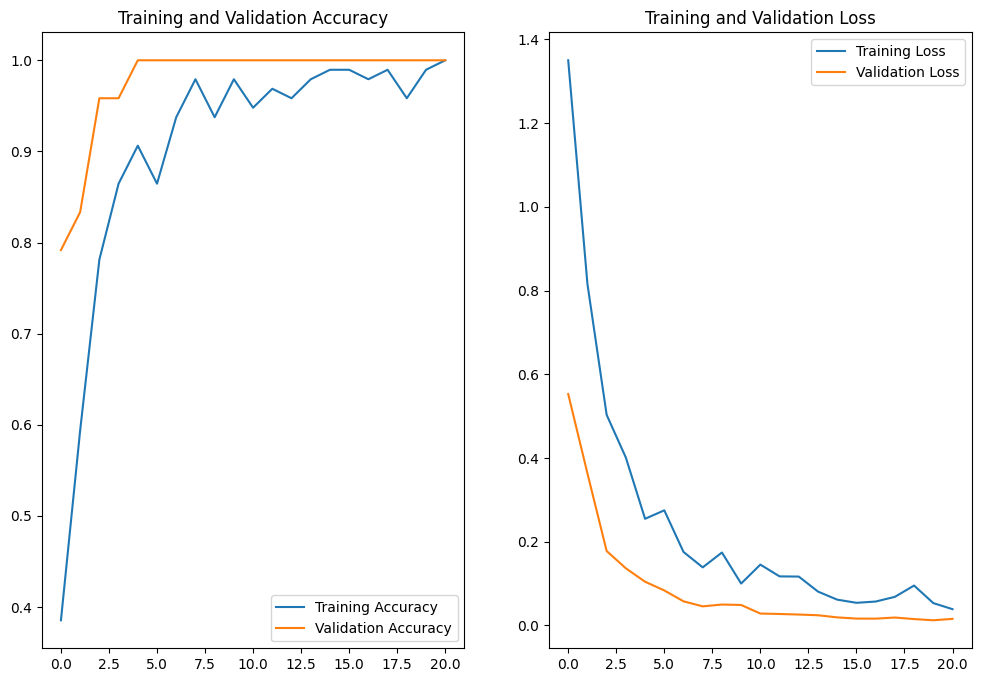

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

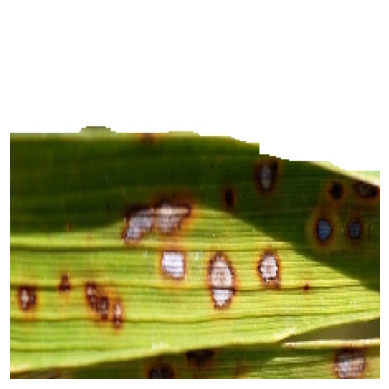

1/1 [==============================] - 2s 2s/step
This image most likely belongs to Brown spot with a 57.53 percent confidence.


In [ ]:
# Path to the image in your Google Drive
test_path = '/content/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0104.jpg'

# Load the image
img = tf.keras.preprocessing.image.load_img(test_path, target_size=(img_height, img_width))
img_array = tf.keras.preprocessing.image.img_to_array(img)

img_array = tf.expand_dims(img_array, 0) # Create a batch

# Print the image
plt.imshow(img)
plt.axis('off')  # Remove axes
plt.show()

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Output the prediction result
class_names = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']  # Define your class names
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

In [ ]:
# Save the model to HDF5 format
model.save("/content/drive/MyDrive/ricediseasemodel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
